In [ ]:
!pip install -q seaborn --upgrade

In [2]:
import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff

%matplotlib inline

In [76]:
from sklearn.linear_model import LinearRegression

# Gathering Our Data

All data is queried from the free statheads.com database

http://statheads.com

Lets start by gathering our player data...

```sql
SELECT
    player_id,
    full_name,
    birthdate,
    college,
    height,
    weight,
    years_pro
FROM player
WHERE position='RB'
ORDER BY years_pro DESC
```

oddly, we only get 148 rows from this query. lets investigate...

```sql
SELECT position, COUNT(*) AS pos_count
FROM player
GROUP BY position
ORDER BY pos_count DESC
```
this query shows us that there are 5223 players with missing positions!

lets look at some of these values. 
- Fortunately (for us), the NFL restricts running backs and defensive backs to the numbers 20-49
- We can also filter out players with more than 300 career passing yards; this will get rid of pesky dual threat quarterbacks like Steve Young, Michael Vick, Russel Wilson, and Cam Newton, while not filtering out running backs like LaDanian Tomlinson
- We can safely drop players with less than 500 career rushing yards. This will get rid of the defensive backs that are still in our dataset after filtering by jersey number. Any running backs with less than 500 career rushing yards will be pretty useless for our analysis anyways

here's our new query, with 251 rows
```sql
SELECT p.* 
FROM player p
    LEFT JOIN player_career c ON p.player_id=c.player_id
WHERE
    p.position = 'RB' OR
    p.position IS NULL AND
    (p.uniform_number BETWEEN 20 AND 49 OR p.uniform_number IS NULL) AND
    c.passing_yds < 300 AND 
    c.rushing_yds > 500
```
some notable running backs with missing position entries:
- Maurice Jones-Drew
- Chris Johnson
- DeAngelo Williams
- Arian Foster
- Ray Rice

**Now lets get per game stats for each running back**

```sql
SELECT
    p.player_id,
    p.team_id,
    p.fumbles_lost,
    p.receiving_rec, p.receiving_yds, p.receiving_tds,
    p.rushing_att,   p.rushing_yds,   p.rushing_tds,
    
    g.start_time, g.day_of_week, g.week, g.season_year,
    g.home_team, g.away_team,
    g.home_score, g.away_score
    
FROM player_game p 
    JOIN game g ON g.game_id=p.game_id
    RIGHT JOIN
    (
     SELECT p.player_id 
     FROM player p
         LEFT JOIN player_career c ON p.player_id=c.player_id
     WHERE
         p.position = 'RB' OR
         p.position IS NULL AND
         (p.uniform_number BETWEEN 20 AND 49 OR p.uniform_number IS NULL) AND
         c.passing_yds < 300 AND 
         c.rushing_yds > 500
    ) rb_ids ON rb_ids.player_id=p.player_id
```

**...and Team Stats for each relevant year**
```sql
```

# EDA

In [4]:
dtypes = {'player_id': int,
          'fumbles_lost': int,
          'receiving_rec': int,
          'receiving_yds': int,
          'receiving_tds': int,
          'rushing_att': int,
          'rushing_yds': int,
          'rushing_tds': int,
          'week': int,
          'season_year': int,
          'home_score': int,
          'away_score': int}


df_game = pd.read_csv('statheads_queries/game_stats.csv')
df_game = df_game.replace('None', np.nan).dropna()
df_game = df_game.astype(dtypes)

df_game.head()

,player_id,team_id,fumbles_lost,receiving_rec,receiving_yds,receiving_tds,rushing_att,rushing_yds,rushing_tds,start_time,day_of_week,week,season_year,home_team,away_team,home_score,away_score
0,2808,PIT,0,0,0,0,4,6,0,08:30:00,thursday,1,2009,PIT,TEN,13,10
1,2813,TEN,0,1,11,0,15,57,0,08:30:00,thursday,1,2009,PIT,TEN,13,10
2,5288,ATL,0,0,0,0,22,65,0,01:00:00,sunday,1,2009,ATL,MIA,19,7
3,123,ATL,0,1,2,0,0,0,0,01:00:00,sunday,1,2009,ATL,MIA,19,7
4,746,MIA,0,3,10,0,10,43,0,01:00:00,sunday,1,2009,ATL,MIA,19,7


## Mean Rushing Stats Per Player

For each year from 2009-2017, lets compute mean rushing and receiving stats per game for each player. Will then plot distributions of each stat to see if there has been any general change in these distributions over time. If the distributions differ significantly, we won't be able to use statistics from earlier seasons as training data.

these plots will be generated in plotly; the data for each year can be toggled on and off, and zoom can be controlled by clicking and dragging over the area of interest.

In [5]:
def plot_stat_dist(stat):
    data = df_game.groupby(['season_year', 'player_id'])[stat].mean().sort_values(ascending=False)
    data_list = [data.loc[year] for year in range(2009, 2018)]
    fig = ff.create_distplot(data_list, range(2009, 2018), show_hist=False, show_rug=False)
    fig['layout'].update(title=stat, height=400, width=800)
    iplot(fig)

In [6]:
plot_stat_dist('rushing_att')

**Rushing Attempts:** 

In recent years there appears to be a movement away from the "bell-cow" running backs who dominate a team's rushing workload. After 2011 there was a significant increase in running backs who averaged less than 5 carries per game, with a large drop off in running backs carrying more than 15 times a game after 2009. Interestingly, the data appears to have some bimodal character in each year, this could be the result of two mixing normal distributions.

In [7]:
plot_stat_dist('rushing_yds')

**Rushing Yards**

We observe similar year-to-year trends here, however the data appears to conform more closely to a normal distribution


In [8]:
plot_stat_dist('rushing_tds')

**Rushing Touchdowns**

Appears to follow a similar trend as the other rushing stats, with a noticable bump in the 2010 distribution at ~0.35 touchdowns per game

In [9]:
plot_stat_dist('receiving_rec')

In [10]:
plot_stat_dist('receiving_yds')

In [11]:
plot_stat_dist('receiving_tds')

**Receiving Stats**

The receiving stats seem to tell a similar story of decreased usage of individual running backs. This could either be indicative of a decrease in the utilization of running backs in modern NFL offenses, or it could be a result of increased specialization of runningbacks, with a similar workload being distributed more evenly across multiple running backs

## Relationships Between Player Traits and Performance

**Bringing in More Data**

It would be ideal if we were able to treat a given player as multiple distinct players for each year that they spend in the league. We would then be able to join this with the main dataset on player_id and current_season and see if player age and years in league have any effect on performance. 

Unfortunately this data is not accessible from the StatHeads.com database so we must look elsewhere. I was able to find some draft data in csv format from kaggle. The only key we can join the datasets on is the full name of the player, which is less than ideal. To ensure that we lose as little data as possible, we will clean the player name text before using it as a joining key

In [62]:
def clean_name(name):
    name = name.lower().strip()
    name = re.sub(r'[^a-z\s]', '', name)
    name = re.sub(r'\s+', ' ', name)
    return name

In [65]:
# import draft data and extract relevant columns
df_draft = pd.read_csv('other_data/nfl_draft.csv')

# column names to lowercase for consistency
df_draft.rename(columns=lambda x: x.lower().strip(), inplace=True)

# filter out non-running backs and extract columns of interest
df_draft = df_draft[df_draft['pos'] == 'RB'][['year', 'pick', 'player', 'age']]

# player names to lowercase to account for differences in capitalization
df_draft['player'] = df_draft['player'].apply(lambda x: clean_name(x))

df_draft.head()

,year,pick,player,age
9,2015,10,todd gurley,21.0
14,2015,15,melvin gordon,22.0
35,2015,36,tj yeldon,21.0
53,2015,54,ameer abdullah,22.0
72,2015,73,tevin coleman,22.0


In [66]:
df_player = pd.read_csv('statheads_queries/player_data.csv')

# player names to lowercase to account for differences in capitalization
df_player['full_name'] = df_player['full_name'].apply(lambda x: clean_name(x))

df_player = df_player.merge(df_draft, how='inner', left_on='full_name', right_on='player')
df_player.drop(columns=['first_name', 'last_name', 'status', 'player', 'position', 'team_id', 'uniform_number', 'birthdate'], inplace=True)

# the dataset represents 0 years as a pro with 'None' entries
df_player['years_pro'] = df_player['years_pro'].replace('None', 0).astype(int)
df_player.head()

,player_id,full_name,college,height,weight,years_pro,year,pick,age
0,251,cj spiller,Clemson,71,200,8,2010,9,23.0
1,496,eddie lacy,Alabama,71,250,5,2013,61,23.0
2,3715,kerwynn williams,Utah State,68,198,4,2013,230,22.0
3,1009,knile davis,Arkansas,70,227,4,2013,96,21.0
4,2363,andre williams,Boston College,72,220,3,2014,113,22.0


In [67]:
player_lst = []
for _, row in df_player.iterrows():
    # generate a 'new' player for each year the player has been in the league
    player = pd.DataFrame({'player_id' : row['player_id'],
                           'full_name' : row['full_name'],
                           'college'   : row['college'],
                           'height'    : row['height'],
                           'weight'    : row['weight'],
                           'years_pro' : np.arange(row['years_pro']),
                           'draft_year': row['year'],
                           'pick'      : row['pick'],
                           'draft_age' : row['age']})
    player_lst.append(player)

player_data = pd.concat(player_lst)
player_data['current_year'] = player_data['draft_year'] + player_data['years_pro']
player_data['current_age']  = player_data['draft_age']  + player_data['years_pro']
player_data.head()

,college,draft_age,draft_year,full_name,height,pick,player_id,weight,years_pro,current_year,current_age
0,Clemson,23.0,2010,cj spiller,71,9,251,200,0,2010,23.0
1,Clemson,23.0,2010,cj spiller,71,9,251,200,1,2011,24.0
2,Clemson,23.0,2010,cj spiller,71,9,251,200,2,2012,25.0
3,Clemson,23.0,2010,cj spiller,71,9,251,200,3,2013,26.0
4,Clemson,23.0,2010,cj spiller,71,9,251,200,4,2014,27.0


In [68]:
df_mean_stats = df_game.groupby(['season_year', 'player_id'])[['fumbles_lost', 'receiving_rec', 'receiving_yds', 'receiving_tds', 'rushing_att', 'rushing_yds', 'rushing_tds']].mean().reset_index()

traits_performance = df_mean_stats.merge(player_data, how='inner', left_on=['player_id', 'season_year'], right_on=['player_id', 'current_year'])
traits_performance.head()

,season_year,player_id,fumbles_lost,receiving_rec,receiving_yds,receiving_tds,rushing_att,rushing_yds,rushing_tds,college,draft_age,draft_year,full_name,height,pick,weight,years_pro,current_year,current_age
0,2009,37,0.142857,2.214286,17.142857,0.000000,8.571429,45.857143,0.071429,Nebraska,22.0,2001,correll buckhalter,72,121,223,8,2009,30.0
1,2009,123,0.071429,2.142857,18.500000,0.071429,10.142857,43.785714,0.285714,Virginia,23.0,2007,jason snelling,71,244,234,2,2009,25.0
2,2009,125,0.133333,1.400000,13.800000,0.000000,10.866667,51.866667,0.466667,Marshall,21.0,2007,ahmad bradshaw,70,250,217,2,2009,23.0
3,2009,201,0.142857,3.357143,23.928571,0.214286,5.000000,27.857143,0.357143,USC,21.0,2006,reggie bush,72,2,205,3,2009,24.0
4,2009,405,0.266667,0.933333,6.600000,0.000000,12.933333,50.466667,0.600000,Minnesota,21.0,2006,laurence maroney,71,21,220,3,2009,24.0


everything should be merged properly and ready for analysis at this point. lets look do a quick sanity check:

In [70]:
traits_performance[traits_performance['full_name'] == "leveon bell"]

,season_year,player_id,fumbles_lost,receiving_rec,receiving_yds,receiving_tds,rushing_att,rushing_yds,rushing_tds,college,draft_age,draft_year,full_name,height,pick,weight,years_pro,current_year,current_age
335,2013,4024,0.076923,3.307692,31.076923,0.000000,18.615385,65.923077,0.615385,Michigan State,21.0,2013,leveon bell,73,48,225,0,2013,21.0
410,2014,4024,0.000000,5.187500,53.375000,0.187500,18.125000,85.062500,0.500000,Michigan State,21.0,2013,leveon bell,73,48,225,1,2014,22.0
489,2015,4024,0.000000,4.000000,22.666667,0.000000,18.833333,92.666667,0.500000,Michigan State,21.0,2013,leveon bell,73,48,225,2,2015,23.0
558,2016,4024,0.083333,6.250000,51.333333,0.166667,21.750000,105.666667,0.583333,Michigan State,21.0,2013,leveon bell,73,48,225,3,2016,24.0
611,2017,4024,0.200000,5.200000,33.900000,0.000000,24.000000,93.500000,0.500000,Michigan State,21.0,2013,leveon bell,73,48,225,4,2017,25.0


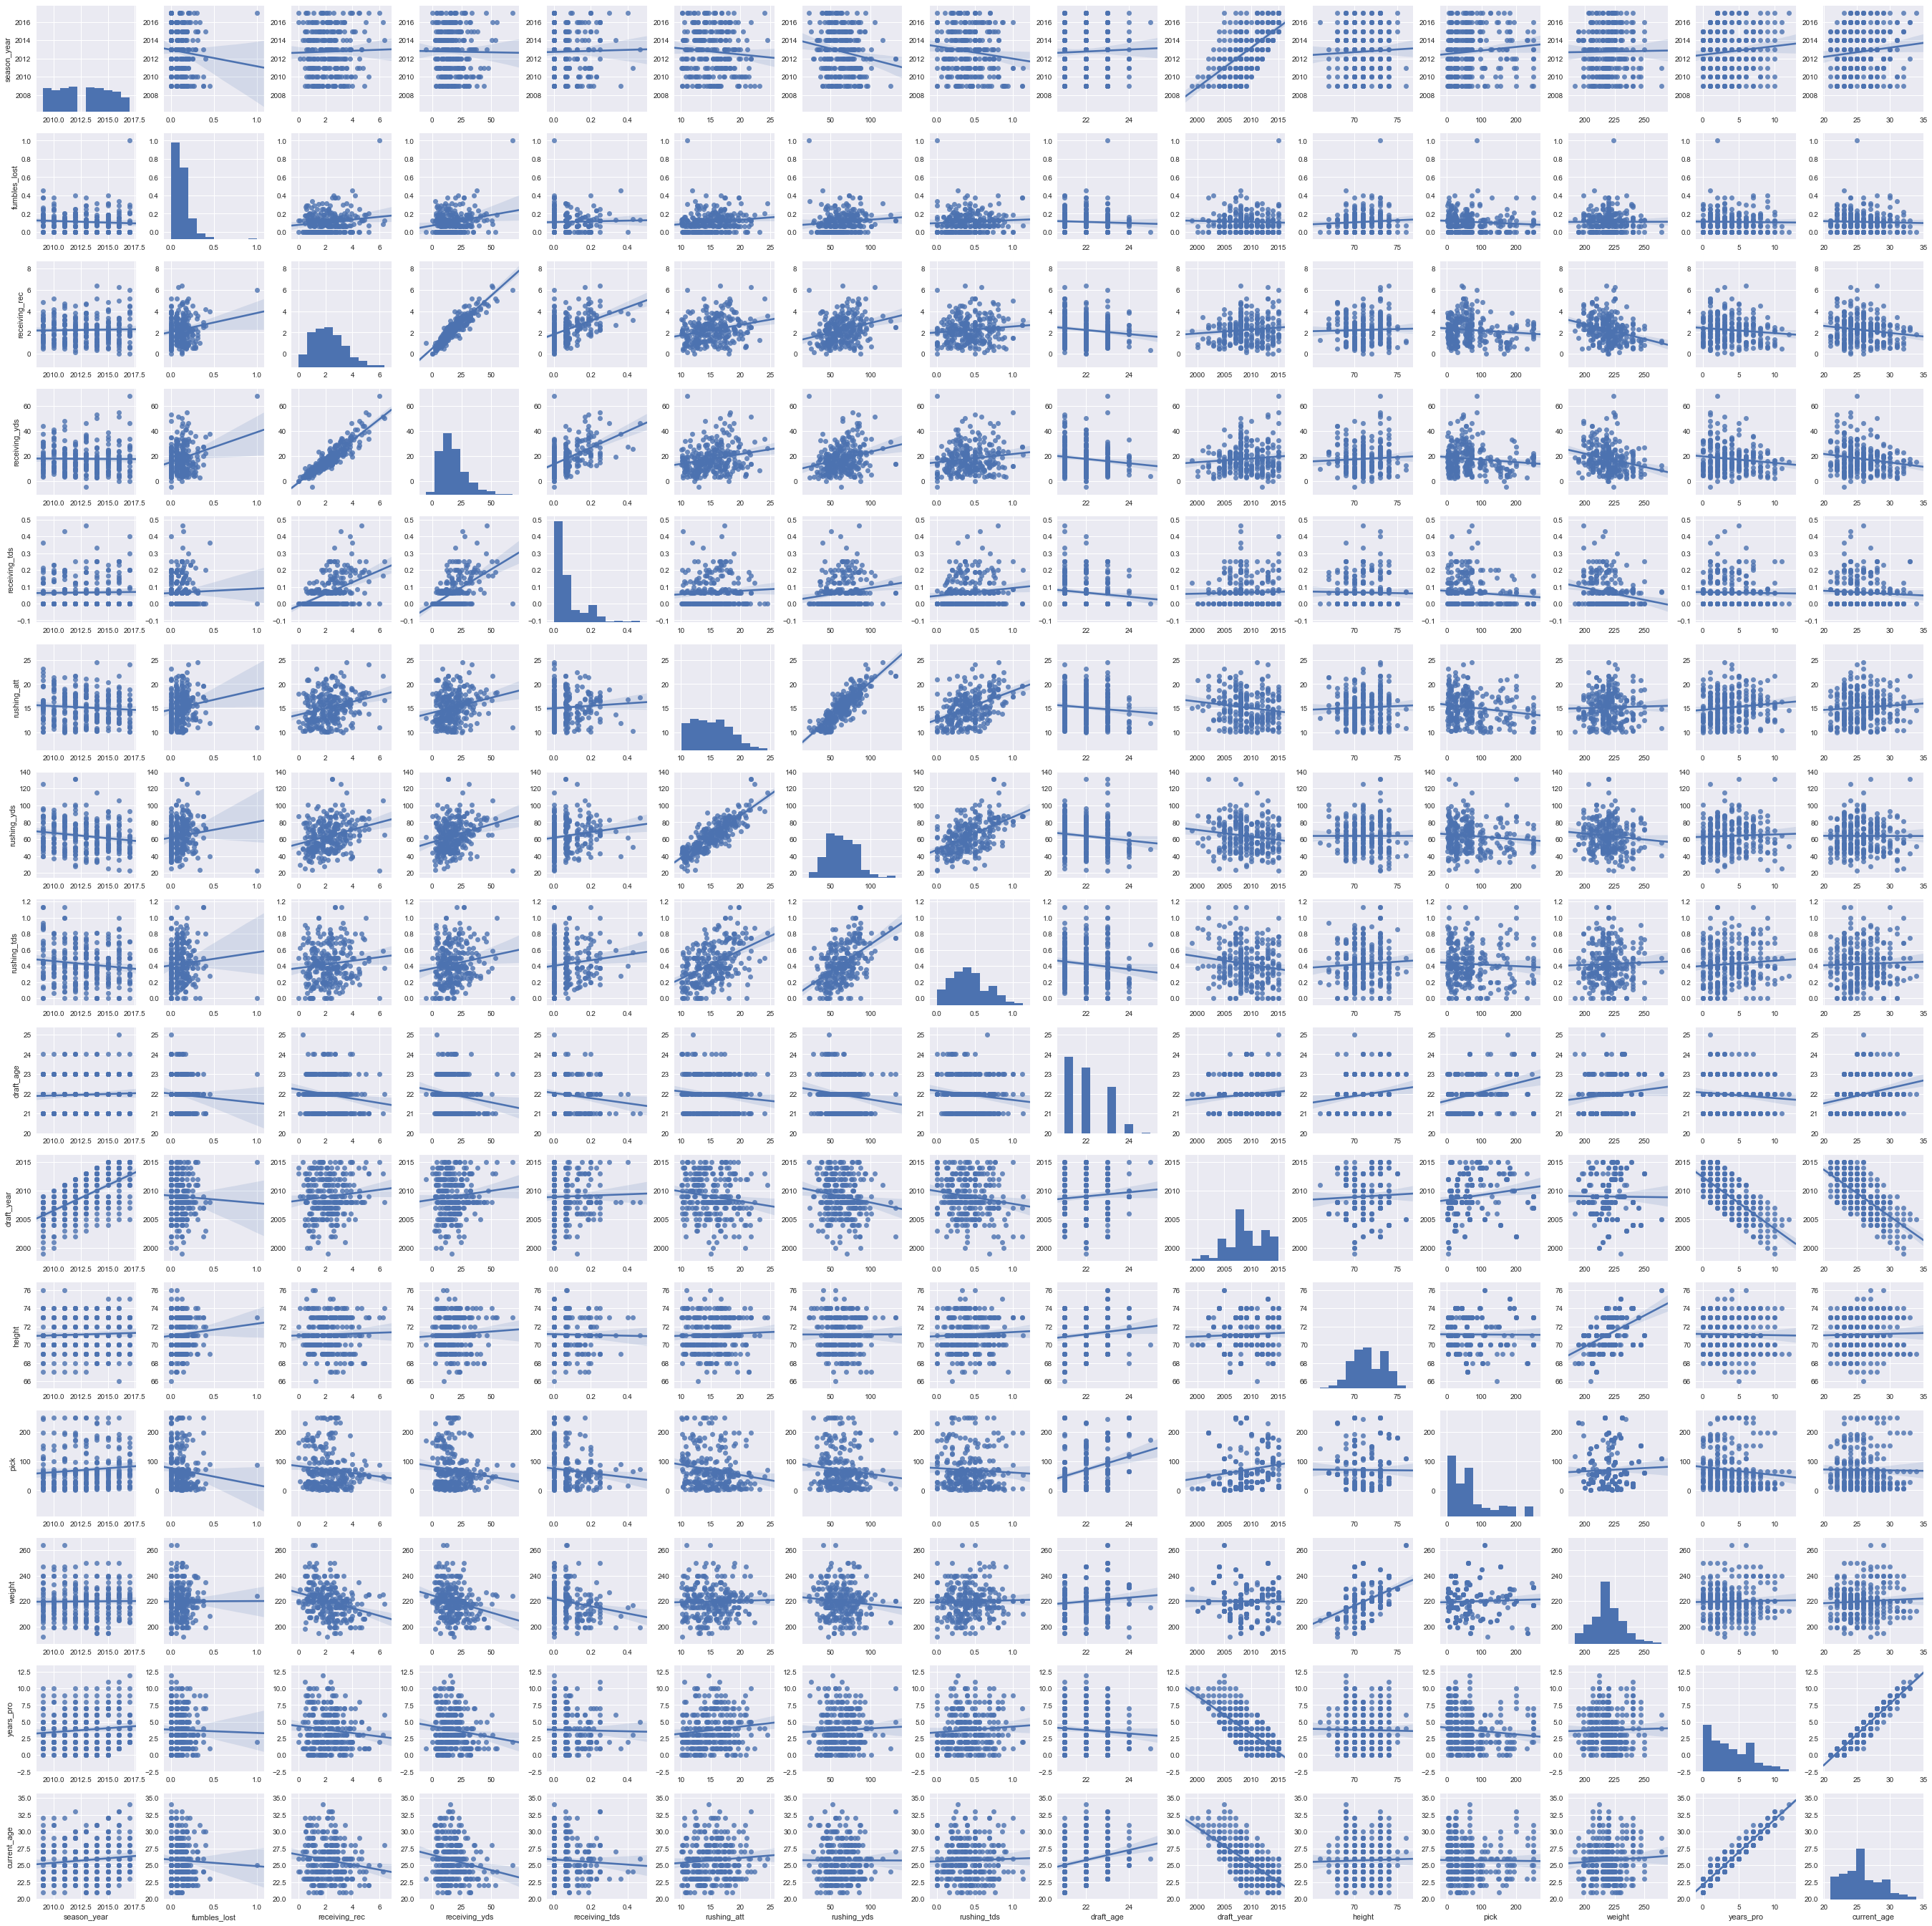

In [74]:
sns.pairplot(traits_performance.drop(columns=['player_id', 'college', 'full_name', 'current_year'])[traits_performance['rushing_att'] > 10], kind='reg')

### Quick Model Test

In [150]:
features = ['season_year', 'draft_age', 'height', 'pick', 'weight', 'years_pro', 'current_age']
targets  = ['rushing_yds']
lr = LinearRegression()

permut = np.random.permutation(traits_performance.shape[0])
permut_tr  = permut[:500].tolist()
permut_tst = permut[500:].tolist()

X_tr = traits_performance.loc[permut_tr, features].values
y_tr = traits_performance.loc[permut_tr, targets].values

X_tst = traits_performance.loc[permut_tst, features].values
y_tst = traits_performance.loc[permut_tst, targets].values

lr.fit(X_tr, y_tr)
lr.score(X_val, y_val)

0.15548679197204884

In [151]:
tst_df = traits_performance.loc[permut_tst]

tst_df['pred_rushing_yds'] = lr.predict(tst_df[features].values)
tst_df['error'] = (tst_df['pred_rushing_yds'] - tst_df['rushing_yds']).abs()
tst_df[['season_year', 'full_name', 'rushing_yds', 'pred_rushing_yds', 'error']].sort_values(by='error', ascending=False).head(10)

,season_year,full_name,rushing_yds,pred_rushing_yds,error
252,2012,alfred morris,100.375000,32.123548,68.251452
418,2014,justin forsett,79.125000,18.189377,60.935623
126,2010,adrian peterson,86.533333,31.988109,54.545224
135,2011,larry johnson,2.000000,52.784634,50.784634
541,2016,andre williams,87.000000,37.575367,49.424633
497,2015,justin forsett,64.100000,16.955259,47.144741
81,2010,andre brown,-1.000000,45.476436,46.476436
114,2010,jamaal charles,91.687500,45.669917,46.017583
24,2009,brian leonard,6.000000,49.660204,43.660204
398,2014,brian leonard,0.000000,43.489613,43.489613


In [153]:
for feat, coef in zip(features, lr.coef_.ravel()):
    print('{:<12} coefficient={}'.format(feat, coef))

season_year  coefficient=-1.1886108848567505
draft_age    coefficient=-2.8442967724266435
height       coefficient=0.36217439229176684
pick         coefficient=-0.09905644363953295
weight       coefficient=0.3298284650208886
years_pro    coefficient=1.3993947077902107
current_age  coefficient=-1.4449020646364321


## Relationships Between Previous Year Team Stats and Performance

In [75]:
traits_performance.shape

(630, 19)